# Spotify podcast dataset: genre reduction and transcript embeddings 
Aditya Chander

2022-10-28
_________

Steps: 

- Make a new metadata table for each individual podcast episode
- Figure out how to average the embeddings & save in new table(s)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [61]:
# !pip install torch
# !pip install pytorch_transformers
# !pip install sentence_transformers

In [3]:
import torch
from pytorch_transformers import BertTokenizer, BertModel
import sentence_transformers

In [4]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/aditya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## New metadata

We're going to keep just the large-scale categories, and if there's more than one of them we'll use just the first one listed. Then, let's examine how many podcasts (and how many transcripts per podcast) we have within each category.

In [5]:
metadata_raw = pd.read_csv('show_categories.tsv', sep='\t')
raw_categories = metadata_raw.columns[3:]
print(list(raw_categories))

['After_Shows', 'Alternative_Health', 'Amateur', 'Animation_and_Manga', 'Arts', 'Automotive', 'Aviation', 'Baseball', 'Basketball', 'Books', 'Buddhism', 'Business', 'Business_News', 'Careers', 'Chemistry', 'Christianity', 'College_and_High_School', 'Comedy', 'Comedy_Fiction', 'Comedy_Interviews', 'Courses', 'Crafts', 'Cricket', 'Daily_News', 'Design', 'Documentary', 'Drama', 'Earth_Sciences', 'Education', 'Education_for_Kids', 'Entertainment_News', 'Entrepreneurship', 'Fantasy_Sports', 'Fashion_and_Beauty', 'Fiction', 'Film_History', 'Film_Interviews', 'Film_Reviews', 'Fitness', 'Food', 'Football', 'Games', 'Games_and_Hobbies', 'Golf', 'Government', 'Health', 'Health_and_Fitness', 'Hinduism', 'History', 'Hobbies', 'Hockey', 'Home_and_Garden', 'How_To', 'Improv', 'Investing', 'Islam', 'Judaism', 'Kids_and_Family', 'Language_Learning', 'Leisure', 'Life_Sciences', 'Literature', 'Management', 'Marketing', 'Mathematics', 'Medicine', 'Mental_Health', 'Music', 'Music_Commentary', 'Music_Histo

In [6]:
super_to_sub = {'arts':['Arts','Books','Design','Fashion_and_Beauty','Food','Performing_Arts','Visual_Arts'],
                'business':['Business','Careers','Entrepreneurship','Investing','Management','Marketing','Non-Profit'],
                'comedy':['Comedy', 'Comedy_Interviews','Improv','Stand-Up'],
                'education':['Education', 'Courses','How_To','Language_Learning','Self-Improvement'],
                'fiction':['Fiction', 'Comedy_Fiction', 'Drama', 'Science_Fiction'],
                'government':['Government'],
                'health_and_fitness':['Health_and_Fitness','Alternative_Health','Fitness','Medicine','Mental_Health','Nutrition','Sexuality'],
                'history':['History'], 
                'kids_and_family':['Kids_and_Family','Education_for_Kids','Parenting','Pets_and_Animals','Stories_for_Kids'],
                'leisure':['Leisure','Animation_and_Manga','Automotive','Aviation','Crafts','Games','Hobbies','Home_and_Garden','Video_Games'],
                'music':['Music','Music_Commentary','Music_History','Music_Interviews'],
                'news':['News','Business_News','Daily_News','Entertainment_News','News_Commentary','Politics','Sports_News','Tech_News'],
                'religion_and_spirituality':['Religion_and_Spirituality','Buddhism','Christianity','Hinduism','Islam','Judaism','Religion','Spirituality'],
                'science':['Science','Astronomy','Chemistry','Earth_Sciences','Life_Sciences','Mathematics',
                           'Natural_Sciences','Nature','Physics','Social_Sciences'],
                'society_and_culture':['Society_and_Culture','Documentary','Personal_Journals','Philosophy','Places_and_Travel','Relationships'],
                'sports':['Sports','Baseball','Basketball','Cricket','Fantasy_Sports','Football','Golf','Hockey','Rugby','Running',
                          'Soccer','Swimming','Tennis','Volleyball','Wilderness','Wrestling'],
                'tv_and_film':['TV_and_Film','After_Shows','Film_History','Film_Interviews','Film_Reviews','TV_Reviews'],
                'technology':['Technology'],
                'true_crime':['True_Crime']
               }

In [7]:
sub_to_super = {subcategory:supercategory for supercategory in super_to_sub for subcategory in super_to_sub[supercategory]}
len(sub_to_super), [x for x in raw_categories if x not in sub_to_super]

(110,
 ['Amateur',
  'College_and_High_School',
  'Games_and_Hobbies',
  'Health',
  'Literature',
  'Outdoor',
  'Podcasting',
  'Self-Help',
  'Sports_and_Recreation'])

Some subcategories are missing; let's put them in appropriate supercategories.

In [8]:
sub_to_super['Amateur'] = 'society_and_culture'
sub_to_super['College_and_High_School'] = 'education'
sub_to_super['Games_and_Hobbies'] = 'leisure'
sub_to_super['Health'] = 'health_and_fitness'
sub_to_super['Literature'] = 'arts'
sub_to_super['Outdoor'] = 'leisure'
sub_to_super['Podcasting'] = 'society_and_culture'
sub_to_super['Self-Help'] = 'health_and_fitness'
sub_to_super['Sports_and_Recreation'] = 'sports'

Now, let's go back to the metadata file and tag the shows with the supercategories.

In [9]:
show_metadata_df = pd.DataFrame()
show_metadata_df['show'] = metadata_raw['show']

def process_categories(categories):
    if categories == 'set()':
        return ''
    category_list = [x.strip()[1:-1] for x in categories[1:-1].split(',')]
    category_list = [x.replace(' ','_').replace('&','and') for x in category_list]
    return sub_to_super[category_list[0]]

show_metadata_df['category'] = metadata_raw['categories'].apply(process_categories)
show_metadata_df = show_metadata_df.set_index('show')

In [54]:
show_metadata_df

,category
show,
show_2NYtxEZyYelR6RMKmjfPLB,leisure
show_15iWCbU7QoO23EndPEO6aN,true_crime
show_0g0gZz74AKcS1MpJJ1T01N,government
show_1dyTrS3vDtpClrURfKdo3q,education
show_162GxLtTwesdY2cVUM4x0H,education
...,...
show_1f0Kj9MZnk8zet8xtsyNDR,science
show_1UqLURSc1vBfAk4ZkiPeXQ,society_and_culture
show_2udB9U1T4YKLbEVPPN0EEj,comedy


<AxesSubplot:>

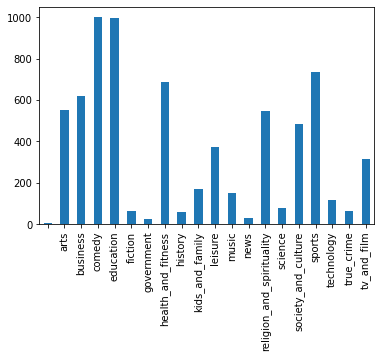

In [10]:
show_metadata_df['category'].value_counts().sort_index().plot.bar()

OK, the classes are definitely not balanced, but let's see the number of actual episodes in each podcast before rejecting anything.

### Load up the episode information only

In [21]:
all_episodes_metadata_df = pd.DataFrame()
for transcript_file in tqdm(sorted(os.listdir('transcript_tables/'))):
    all_episodes_metadata_df = pd.concat([all_episodes_metadata_df, pd.read_csv(f'transcript_tables/{transcript_file}', sep='\t', usecols=['show','episode'])])

all_episodes_metadata_df.reset_index(inplace=True,drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 19.62it/s]


In [22]:
all_episodes_metadata_df['category'] = all_episodes_metadata_df['show'].apply(lambda x: show_metadata_df.loc[x].category)

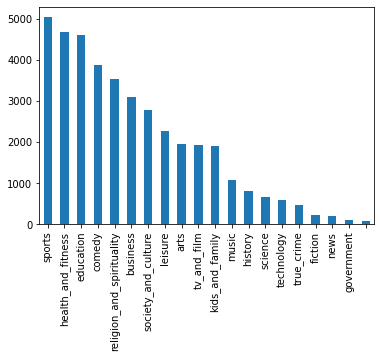

sports                       5038
health_and_fitness           4668
education                    4617
comedy                       3877
religion_and_spirituality    3526
business                     3106
society_and_culture          2779
leisure                      2270
arts                         1949
tv_and_film                  1928
kids_and_family              1914
music                        1087
history                       818
science                       655
technology                    600
true_crime                    468
fiction                       222
news                          203
government                     95
                               72
Name: category, dtype: int64


In [23]:
all_episodes_metadata_df.category.value_counts().plot.bar()
plt.show()
print(all_episodes_metadata_df.category.value_counts())

For now, let's not consider the categories with fewer than 500 episodes. 

### Load up the transcripts 

In [59]:
all_episodes_transcripts_df = pd.DataFrame()
for transcript_file in tqdm(sorted(os.listdir('transcript_tables/'))):
    all_episodes_transcripts_df = pd.concat([all_episodes_transcripts_df, pd.read_csv(f'transcript_tables/{transcript_file}', sep='\t')])

all_episodes_transcripts_df.reset_index(inplace=True)
all_episodes_transcripts_df.drop(columns=['index','Unnamed: 0'], inplace=True)



  0%|                                                                                                                                                            | 0/108 [00:00<?, ?it/s]

  2%|██▋                                                                                                                                                 | 2/108 [00:00<00:09, 10.63it/s]

  4%|█████▍                                                                                                                                              | 4/108 [00:00<00:09, 11.36it/s]

  6%|█████████▌                                                                                                                                          | 7/108 [00:00<00:06, 15.58it/s]

  8%|████████████▎                                                                                                                                       | 9/108 [00:00<00:05, 16.66it/s]

 10%|██████████████▉                                           

### Testing how embeddings work

In [16]:
sample_transcript = all_episodes_transcripts_df['transcript'].iloc[0]
sample_sentences = nltk.sent_tokenize(sample_transcript)
sample_sentences

['Welcome back to GRE vocab.',
 'Before we continue.',
 'We just want to give a quick shout out to the people who make this podcast possible.',
 'Anchor anchor is everything you need to make a podcast in one place.',
 'They distribute your podcast for you.',
 'They have tools that allow you to record and edit everything right from your phone or computer.',
 "It's free the even allow you to put ads in your your podcast.",
 "It's pretty awesome.",
 'Go check it out download the free anchor app or go to Anchored off dot f m-- to get started.',
 "Okay, let's get back to the show.",
 "Today's words are fatuous, silly and pointless apocryphal.",
 'Of doubtful authenticity, although widely circulated as being true usually in regards to a story or statement a credit e having an acrid smell accurate is having an irritant Lee Strong and unpleasant taste or smell angry bitter.',
 'Trench in see in size of - keenness and forcefulness of thought or expression or intellect euphony the quality of bei

In [17]:
model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')

In [18]:
sample_embeddings = model.encode(sample_sentences)
# np.mean(sample_embeddings, axis=0) # <-- this is what we want 

### Make the embeddings for all the transcripts

The sentence averaging took a super long time, so I encoded the entirety of the transcript instead.

In [36]:
model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2') # swap this out for whichever model you want

In [41]:
episode_ids = []
transcript_embeddings = []
for i in range(len(all_episodes_transcripts_df)):
    if (i+1) % 50 == 0:
        print(f'finished {i+1} transcripts')
    episode_ids.append(all_episodes_metadata_df['episode'].iloc[i])
    transcript = all_episodes_transcripts_df['transcript'].iloc[i]
    transcript_embeddings.append(model.encode(transcript))

finished 50 transcripts
finished 100 transcripts
finished 150 transcripts
finished 200 transcripts
finished 250 transcripts
finished 300 transcripts
finished 350 transcripts
finished 400 transcripts
finished 450 transcripts
finished 500 transcripts
finished 550 transcripts
finished 600 transcripts
finished 650 transcripts
finished 700 transcripts
finished 750 transcripts
finished 800 transcripts
finished 850 transcripts
finished 900 transcripts
finished 950 transcripts
finished 1000 transcripts
finished 1050 transcripts
finished 1100 transcripts
finished 1150 transcripts
finished 1200 transcripts
finished 1250 transcripts
finished 1300 transcripts
finished 1350 transcripts
finished 1400 transcripts
finished 1450 transcripts
finished 1500 transcripts
finished 1550 transcripts
finished 1600 transcripts
finished 1650 transcripts
finished 1700 transcripts
finished 1750 transcripts
finished 1800 transcripts
finished 1850 transcripts
finished 1900 transcripts
finished 1950 transcripts
finish

In [51]:
transcript_embeddings_array = np.asarray(transcript_embeddings)

(384, 39892)

In [60]:
minilm_df = pd.DataFrame(transcript_embeddings_array)
minilm_df['episode_id'] = episode_ids
minilm_df['show_id'] = all_episodes_metadata_df['show']
minilm_df['category'] = all_episodes_metadata_df['category']
minilm_df = minilm_df[list(minilm_df.columns[-3:]) + list(minilm_df.columns[:-3])]
minilm_df

,episode_id,show_id,category,0,1,2,3,4,5,6,...,374,375,376,377,378,379,380,381,382,383
0,2VVBXyGRGd2cydXPxHJme6,show_00iaP2GhJUWHAovx41BN5N,education,-0.012944,-0.098197,0.028915,-0.030774,0.016051,0.018553,0.050893,...,0.016638,0.064347,-0.002495,-0.019543,-0.042851,0.051849,0.025960,0.017131,0.013270,0.056515
1,3jIQUvPSaCcMOpJfx5AB1w,show_00iaP2GhJUWHAovx41BN5N,education,0.009631,-0.068866,-0.009473,-0.091188,0.043809,0.056622,0.067636,...,0.042963,0.051800,0.003616,-0.007825,-0.016031,-0.000885,0.053383,0.097969,-0.015768,0.041006
2,3iRJkm19fnZkdwW7nTX5Yb,show_00iaP2GhJUWHAovx41BN5N,education,-0.005621,-0.058381,-0.007130,-0.080090,-0.010751,0.013268,0.050912,...,0.016412,0.005360,0.012701,-0.021304,-0.035279,0.011132,-0.009373,0.048529,0.036826,0.061430
3,3vdykhEg3lYhfXEVIIB8GH,show_00iaP2GhJUWHAovx41BN5N,education,-0.007286,-0.063669,-0.015736,-0.108655,0.032804,0.079848,0.041044,...,0.038290,0.071165,-0.003925,-0.001461,-0.020981,0.026963,0.009998,0.029192,-0.015249,0.051511
4,4Xsex7XPthez6srVIdv4vU,show_00iaP2GhJUWHAovx41BN5N,education,0.094888,0.001547,-0.030290,-0.013661,0.026258,-0.028358,0.145540,...,-0.019703,-0.017592,-0.016142,0.060258,-0.102286,0.035341,0.099274,-0.004880,0.022388,-0.042188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39887,6p4wARRoyULG9S2IQFRMYe,show_2zwCSqNh7sb7iMXG7WAus9,government,0.076757,0.008891,0.076580,0.015433,0.163450,-0.028056,-0.017725,...,0.010196,0.025638,-0.022989,0.080084,-0.001355,0.047681,-0.001463,-0.068126,-0.094104,0.014751
39888,3QRHueGLTkqwyR28gC4yUq,show_2zwCSqNh7sb7iMXG7WAus9,government,0.025046,-0.015150,0.079848,0.039370,0.162951,-0.032224,-0.092736,...,0.098953,-0.040016,-0.042995,0.072578,0.006651,-0.051871,-0.001952,-0.119598,-0.011600,-0.003372
39889,2kJkGRhcGZDEumoMllxLTT,show_2Z3X5kJDGyjKwkXtq16kzR,arts,-0.017483,0.066785,0.133168,0.016252,0.065321,-0.042118,0.009978,...,0.082223,0.016189,-0.039932,-0.059751,0.005505,0.023128,0.084194,0.005873,-0.121605,0.012384
39890,3AHQCGfshsjCYxzrNj7YDL,show_2zpvSmm7aTdwICTtzdw6oQ,education,-0.065693,-0.035627,0.021421,0.037326,-0.004394,0.003341,0.011911,...,0.052406,0.084168,-0.109444,0.059805,-0.038799,0.061102,0.031428,-0.002785,-0.140267,0.045347


Columns to have for final export:
- episode_id
- show_id
- category (reduced down from itunes)
- embedding columns

In [62]:
minilm_df.to_csv('transcript_embeddings_minilm-l6-v2.csv')